# Comparison between methods in terms of MSE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ManifoldSculpting import ManifoldSculpting
from sklearn.datasets import make_s_curve
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(0)

In [3]:
def swiss_roll(n_samples):
	"""
	Parameters:
	n: int
		Number of points to generate
	
	Returns:
	data: np.array
		An array of shape (n, 4) where the first column is the x-coordinate, the second column is the y-coordinate, the third column is the z-coordinate, 
		and the fourth column is the color of the points
	"""

	data = np.zeros((n_samples,4))
	t = np.array([2+8*i/n_samples for i in range(n_samples)])
	data[:,0] = t*np.sin(t)
	data[:,2] = t*np.cos(t)
	data[:,1] = np.random.uniform(-6,6,n_samples)
	data[:,3] = t
	return data


In [4]:
def plot_mse_comparison(errors, neigh_range, filepath):
	plt.figure(figsize=(10,5))
	for name, err in errors.items():
		plt.plot(neigh_range, err, label=name)

	plt.yscale('log')
	plt.xlabel('Number of neighbors')
	plt.ylabel('Mean Squared Error')
	plt.title('Mean Squared Error comparison')
	plt.legend()
	plt.grid(True, which='both', linestyle='--')
	plt.savefig(filepath)
	plt.show()

In [5]:
def run_swiss_roll(n_samples):

	data = swiss_roll(n_samples)
	roll = data[:,:3].astype(np.float32)
	roll = roll - np.mean(roll,axis=0)
	phi = data[:,-1]

	correct_manifold = data[:, [3,1]]
	scaler = MinMaxScaler()

	correct_manifold = scaler.fit_transform(correct_manifold)

	neigh_range = [10, 15, 20, 25, 30, 40]

	algorithms = {
		'Manifold Sculpting': ManifoldSculpting(sigma=0.98, niter=800, apply_pca=True, patience=100),  # Increased iterations for precision
		'Isomap': Isomap(n_components=2, n_jobs=-1),
		'LLE': LocallyLinearEmbedding(n_components=2, n_jobs=-1),  # Reduced reg for LLE
		'HLLE': LocallyLinearEmbedding(n_components=2, method='hessian', n_jobs=-1) # HLLE optimized
	}

	errors = {name : [] for name in algorithms.keys()}

	for i in neigh_range:
		print(f"\nRunning for n_neighbors = {i}")

		for name, algo in algorithms.items():

			if hasattr(algo, 'n_neighbors'):
				algo.n_neighbors = i

			try:
				embedding = algo.fit_transform(roll.copy())
			except:
				print(f"Failed for {name} with n_neighbors = {i}")
				continue

			# Center data and put it on principal axes
			scaled_emb = embedding - np.mean(embedding,axis=0)

			# Compute principal axes
			pca = np.linalg.svd(scaled_emb,full_matrices=False)[2]
			scaled_emb = scaled_emb @ pca.T

			scaled_emb = scaler.fit_transform(scaled_emb)
			mse = mean_squared_error(correct_manifold, scaled_emb[:, [0,1]])
			errors[name].append(mse)
			print(f"{name} with n_neighbors = {i} completed!")

	mse_df = pd.DataFrame(errors, index=neigh_range)
	mse_df.to_csv('data/swiss_roll_mse.csv')

In [6]:
if __name__ == '__main__':
	run_swiss_roll(1000)


Running for n_neighbors = 10


Initial adjustment: 228it [03:36,  1.05it/s]
Main loop:  50%|████▉     | 397/800 [02:38<02:40,  2.51it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 10 completed!


Isomap with n_neighbors = 10 completed!
LLE with n_neighbors = 10 completed!
HLLE with n_neighbors = 10 completed!

Running for n_neighbors = 15


Initial adjustment: 228it [03:36,  1.05it/s]
Main loop:  56%|█████▋    | 451/800 [03:31<02:43,  2.13it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 15 completed!


Isomap with n_neighbors = 15 completed!
LLE with n_neighbors = 15 completed!
HLLE with n_neighbors = 15 completed!

Running for n_neighbors = 20


Initial adjustment: 228it [03:51,  1.01s/it]
Main loop:  48%|████▊     | 380/800 [02:39<02:56,  2.38it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 20 completed!


Isomap with n_neighbors = 20 completed!
LLE with n_neighbors = 20 completed!
HLLE with n_neighbors = 20 completed!

Running for n_neighbors = 25


Initial adjustment: 228it [04:01,  1.06s/it]
Main loop:  44%|████▍     | 355/800 [02:12<02:46,  2.67it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 25 completed!


Isomap with n_neighbors = 25 completed!
LLE with n_neighbors = 25 completed!
HLLE with n_neighbors = 25 completed!

Running for n_neighbors = 30


Initial adjustment: 228it [04:09,  1.09s/it]
Main loop:  52%|█████▏    | 416/800 [03:31<03:15,  1.96it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 30 completed!


Isomap with n_neighbors = 30 completed!
LLE with n_neighbors = 30 completed!
HLLE with n_neighbors = 30 completed!

Running for n_neighbors = 40


Initial adjustment: 228it [04:26,  1.17s/it]
Main loop:  46%|████▌     | 368/800 [02:45<03:14,  2.23it/s] 

Convergence reached by patience
Manifold Sculpting with n_neighbors = 40 completed!


Isomap with n_neighbors = 40 completed!
LLE with n_neighbors = 40 completed!
HLLE with n_neighbors = 40 completed!


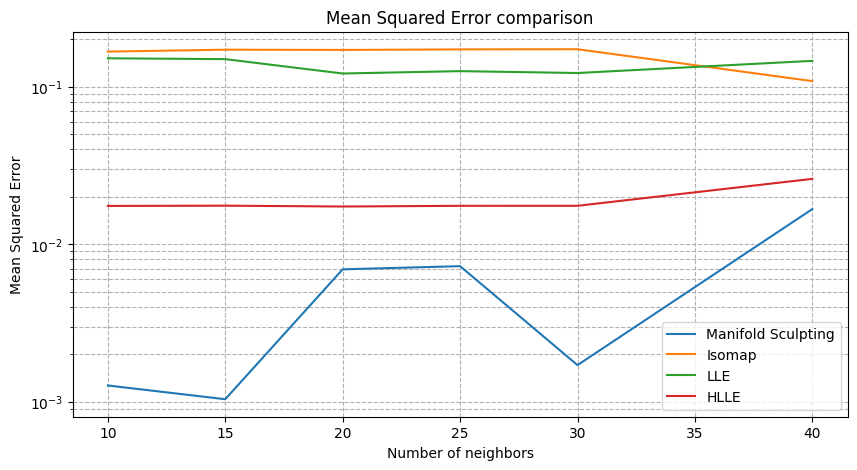

In [13]:
errors_df = pd.read_csv('data/swiss_roll_mse.csv', index_col=0)

plt.figure(figsize=(10,5))
for col in errors_df.columns:
	plt.plot(errors_df.index, errors_df[col], label=col)

plt.yscale('log')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error comparison')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.savefig('plots/mse_comparison_neigh.png')
plt.show()

Comparison on the s-curve manifold

In [8]:
neighbors = 20

def generate_s_curve(X):
	X, t = make_s_curve(n_samples=1000)
	X = np.column_stack((X, t))
	return X

def run_s_curve():
    
	n_points = [250, 353, 500, 707, 1000, 1414]

	algorithms = {
		'Manifold Sculpting': ManifoldSculpting(n_neighbors=neighbors, sigma=0.98, niter=800, apply_pca=True, patience=100),  # Increased iterations for precision
		'Isomap': Isomap(n_neighbors=neighbors, n_components=2, n_jobs=-1),
		'LLE': LocallyLinearEmbedding(n_neighbors=neighbors, n_components=2, n_jobs=-1),  # Reduced reg for LLE
		'HLLE': LocallyLinearEmbedding(n_neighbors=neighbors, n_components=2, method='hessian', n_jobs=-1) # HLLE optimized
	}

	errors = {name : [] for name in algorithms.keys()}

	for n in n_points:
		print(f"\nRunning for n = {n}")
		data = generate_s_curve(n)

		surf = data[:,:3].astype(np.float32)
		surf = surf - np.mean(surf,axis=0)
		phi = data[:,-1]

		correct_manifold = data[:, [3,1]]
		scaler = MinMaxScaler()

		correct_manifold = scaler.fit_transform(correct_manifold)

		for name, algo in algorithms.items():
			try:
				embedding = algo.fit_transform(surf.copy())
			except:
				print(f"Failed for {name} with n = {n}")
				continue

			# Center data and put it on principal axes
			scaled_emb = embedding - np.mean(embedding,axis=0)

			# Compute principal axes
			pca = np.linalg.svd(scaled_emb,full_matrices=False)[2]
			scaled_emb = scaled_emb @ pca.T

			scaled_emb = scaler.fit_transform(scaled_emb)
			mse = mean_squared_error(correct_manifold, scaled_emb[:, [0,1]])
			errors[name].append(mse)
			print(f"{name} with n = {n} completed!")

	mse_df = pd.DataFrame(errors, index=n_points)
	mse_df.to_csv('data/s_curve_mse.csv')

In [9]:
if __name__ == '__main__':
	run_s_curve()


Running for n = 250


Initial adjustment: 228it [04:00,  1.06s/it]
Main loop:  49%|████▉     | 391/800 [02:51<02:59,  2.28it/s] 

Convergence reached by patience
Manifold Sculpting with n = 250 completed!


Isomap with n = 250 completed!
LLE with n = 250 completed!
HLLE with n = 250 completed!

Running for n = 353


Initial adjustment: 228it [04:01,  1.06s/it]
Main loop:  46%|████▋     | 371/800 [02:29<02:53,  2.48it/s] 

Convergence reached by patience
Manifold Sculpting with n = 353 completed!


Isomap with n = 353 completed!
LLE with n = 353 completed!
HLLE with n = 353 completed!

Running for n = 500


Initial adjustment: 228it [04:05,  1.08s/it]
Main loop:  60%|█████▉    | 478/800 [04:24<02:57,  1.81it/s] 

Convergence reached by patience
Manifold Sculpting with n = 500 completed!


Isomap with n = 500 completed!
LLE with n = 500 completed!
HLLE with n = 500 completed!

Running for n = 707


Initial adjustment: 228it [04:10,  1.10s/it]
Main loop:  64%|██████▍   | 510/800 [05:13<02:58,  1.63it/s] 

Convergence reached by patience
Manifold Sculpting with n = 707 completed!


Isomap with n = 707 completed!
LLE with n = 707 completed!
HLLE with n = 707 completed!

Running for n = 1000


Initial adjustment: 228it [03:55,  1.03s/it]
Main loop:  46%|████▌     | 368/800 [02:26<02:51,  2.51it/s] 

Convergence reached by patience
Manifold Sculpting with n = 1000 completed!


Isomap with n = 1000 completed!
LLE with n = 1000 completed!
HLLE with n = 1000 completed!

Running for n = 1414


Initial adjustment: 228it [04:08,  1.09s/it]
Main loop:  48%|████▊     | 387/800 [02:44<02:55,  2.35it/s] 

Convergence reached by patience
Manifold Sculpting with n = 1414 completed!


Isomap with n = 1414 completed!
LLE with n = 1414 completed!
HLLE with n = 1414 completed!


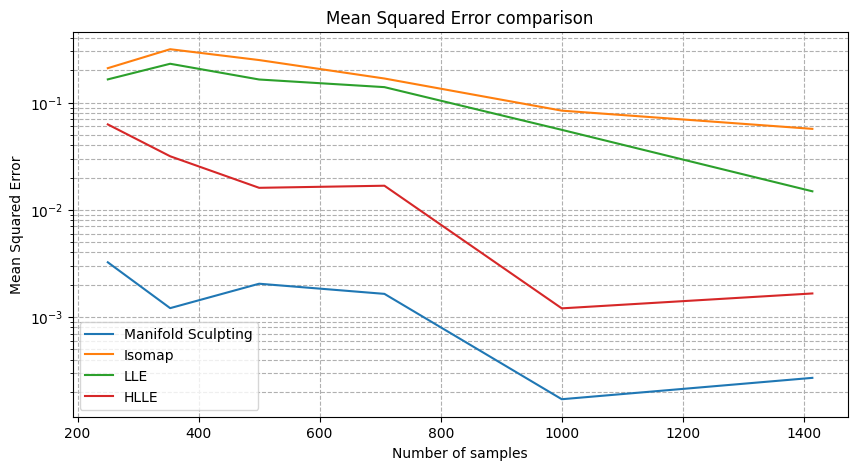

In [19]:
errors_df = pd.read_csv('data/s_curve_mse.csv', index_col=0)

plt.figure(figsize=(10,5))
for col in errors_df.columns:
	plt.plot(errors_df.index, errors_df[col], label=col)

plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error comparison')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.savefig('plots/mse_comparison_samples.png')
plt.show()